# 1. Load Data & Packages

In [1]:
# Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error,  r2_score, accuracy_score
from sklearn.model_selection import train_test_split


2023-12-05 15:29:40.925234: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 15:29:40.956398: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 15:29:40.956439: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 15:29:40.957697: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 15:29:40.964792: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Read data from the CSV file into a DataFrame
data = pd.read_csv("/home/tony/code/oscarlee8787/price_prediction/raw_data/LTC-USD.csv")
print(data.head(0))

# Select specific columns from the DataFrame
data = data.loc[:,['Date','Open','High','Low','Close','Volume']]

print(data.head(5))
print(data.shape)


Empty DataFrame
Columns: [Date, Open, High, Low, Close, Adj Close, Volume]
Index: []
         Date        Open        High         Low       Close      Volume
0  2018-01-01  231.666000  236.634003  222.203003  229.033005   633142016
1  2018-01-02  228.990005  263.625000  228.990005  255.684006  1237949952
2  2018-01-03  255.695007  260.742004  243.134995  245.367996  3215280128
3  2018-01-04  245.475006  245.475006  227.013000  241.369995  3481550080
4  2018-01-05  241.033997  256.148010  237.880005  249.270996  1710599936
(2159, 6)


In [3]:
# Set the 'Date' column as the index of the DataFrame
data = data.set_index('Date')
# Convert the index to datetime format
data.index = pd.to_datetime(data.index,unit='ns')
print(data.head)


<bound method NDFrame.head of                   Open        High         Low       Close      Volume
Date                                                                  
2018-01-01  231.666000  236.634003  222.203003  229.033005   633142016
2018-01-02  228.990005  263.625000  228.990005  255.684006  1237949952
2018-01-03  255.695007  260.742004  243.134995  245.367996  3215280128
2018-01-04  245.475006  245.475006  227.013000  241.369995  3481550080
2018-01-05  241.033997  256.148010  237.880005  249.270996  1710599936
...                ...         ...         ...         ...         ...
2023-11-25   70.738464   72.083138   70.652245   71.833366   237235479
2023-11-26   71.836105   71.846375   69.429031   70.058990   257792066
2023-11-27   70.055466   70.459503   68.280457   69.242332   261741816
2023-11-28   69.244240   70.164375   68.111427   69.737251   340266606
2023-11-29   69.737106   70.413788   69.599037   69.820290   323066656

[2159 rows x 5 columns]>


# 2. Preprocess Data

In [4]:
#Set the Target column
aim = 'Close'


In [5]:
# Determine the index for the 80-20 split
split_index = int(len(data) * 0.8)

# Split the data into training and testing sets
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    """
    Create a line plot with two lines.
    Parameters:
    - line1 (array-like): Data for the first line.
    - line2 (array-like): Data for the second line.
    - label1 (str, optional): Label for the first line (default is None).
    - label2 (str, optional): Label for the second line (default is None).
    - title (str, optional): Title of the plot (default is an empty string).
    - lw (int, optional): Line width for both lines (default is 2).
    """
    # Create a subplot with specified size
    fig, ax = plt.subplots(1, figsize=(13, 7))

    # Plot the first line with its label
    ax.plot(line1, label=label1, linewidth=lw)

    # Plot the second line with its label
    ax.plot(line2, label=label2, linewidth=lw)

    # Set y-axis label
    ax.set_ylabel('BTC/USDT', fontsize=14)

    # Set the title
    ax.set_title(title, fontsize=16)

    # Add a legend at the best location with the specified font size
    ax.legend(loc='best', fontsize=16)

    # Display the plot
    plt.show()


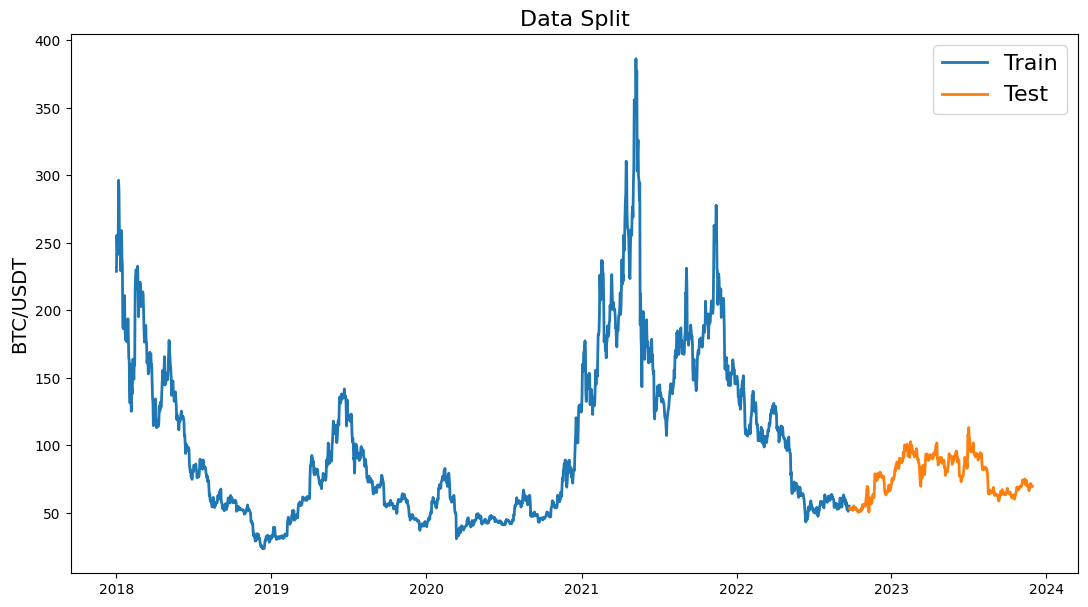

In [6]:
# Plotting the training and testing data for the 'Close' column
line_plot(train_data[aim], test_data[aim], label1='Train', label2='Test', title='Data Split')


In [7]:
# Function to normalize a continuous variable to a zero-base scale
def normalise_zero_base(continuous):
    """
    Normalize a continuous variable to a zero-base scale.
    Parameters:
    - continuous (pandas.Series): The continuous variable to be normalized.
    Returns:
    - pandas.Series: The normalized continuous variable.
    """
    # Normalize by dividing each value by the first value and subtracting 1
    return continuous / continuous.iloc[0] - 1


# Function to normalize a continuous variable to a min-max scale
def normalise_min_max(continuous):
    """
    Normalize a continuous variable to a min-max scale.
    Parameters:
    - continuous (pandas.Series): The continuous variable to be normalized.
    Returns:
    - pandas.Series: The normalized continuous variable.
    """
    # Normalize using min-max scaling formula
    return (continuous - continuous.min()) / (continuous.max() - continuous.min())


In [8]:
# Function to extract windowed data from a continuous variable
def extract_window_data(continuous, window_len=5, zero_base=True):
    """
    Extract windowed data from a continuous variable.
    Parameters:
    - continuous (pandas.Series): The continuous variable to extract windows from.
    - window_len (int, optional): The length of each window (default is 5).
    - zero_base (bool, optional): Whether to normalize each window to a zero-base scale (default is True).
    Returns:
    - numpy.ndarray: Array of windowed data.
    Example:
    >>> windowed_data = extract_window_data(data['Close'], window_len=10, zero_base=True)
    """
    # Initialize an empty list to store windowed data
    window_data = []

    # Iterate over the continuous variable to extract windows
    for idx in range(len(continuous) - window_len):
        # Extract a window of data
        tmp = continuous[idx: (idx + window_len)].copy()

        # Normalize the window to a zero-base scale if specified
        if zero_base:
            tmp = normalise_zero_base(tmp)

        # Append the window data to the list
        window_data.append(tmp.values)

    # Convert the list of windowed data to a numpy array
    return np.array(window_data)


In [9]:
# Function to prepare data for time series analysis
def prepare_data(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
    """
    Prepare data for time series analysis.
    Parameters:
    - continuous (pandas.Series): The continuous variable for time series analysis.
    - aim (str): The target variable to predict.
    - window_len (int, optional): The length of each window (default is 10).
    - zero_base (bool, optional): Whether to normalize each window to a zero-base scale (default is True).
    - test_size (float, optional): The proportion of data to be used as the test set (default is 0.2).
    Returns:
    - tuple: A tuple containing train_data, test_data, X_train, X_test, y_train, y_test.
    """
    # Extract windowed data for training and testing sets
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)

    # Extract target variable for training and testing sets
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values

    # Normalize the target variable to a zero-base scale if specified
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    # Return the prepared data
    return train_data, test_data, X_train, X_test, y_train, y_test


# 3. LSTM Model

In [10]:
# Function to build an LSTM (Long Short-Term Memory) model# Function to build an LSTM (Long Short-Term Memory) model
def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    """
    Build an LSTM (Long Short-Term Memory) model.
    Parameters:
    - input_data (numpy.ndarray): The input data for the model.
    - output_size (int): The size of the output layer.
    - neurons (int): The number of neurons in the LSTM layer.
    - activ_func (str, optional): Activation function for the output layer (default is 'linear').
    - dropout (float, optional): Dropout rate to prevent overfitting (default is 0.2).
    - loss (str, optional): Loss function for model training (default is 'mse' - Mean Squared Error).
    - optimizer (str, optional): Optimization algorithm for model training (default is 'adam').
    Returns:
    - tensorflow.keras.models.Sequential: The constructed LSTM model.
    """
    # Create a Sequential model
    model = Sequential()

    # Add an LSTM layer with the specified number of neurons and input shape
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))

    # Add a Dropout layer to prevent overfitting
    model.add(Dropout(dropout))

    # Add a Dense layer with the specified number of units
    model.add(Dense(units=output_size))

    # Add an Activation layer with the specified activation function
    model.add(Activation(activ_func))

    # Compile the model with the specified loss function and optimizer
    model.compile(loss=loss, optimizer=optimizer)

    # Return the constructed LSTM model
    return model


In [11]:
# Define parameters for data preparation and LSTM model
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
output_size=1

# Prepare data for time series analysis
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)


In [12]:
print(X_train.shape)


(1722, 5, 5)


In [13]:
# Build an LSTM model
model = build_lstm_model(
    X_train, output_size=output_size, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)

# Train the LSTM model
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=False)


2023-12-05 15:29:43.597737: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 15:29:43.637628: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
54/54 [==============================] - 1s 8ms/step - loss: 0.0129 - val_loss: 0.0037
Epoch 2/20
54/54 [==============================] - 0s 3ms/step - loss: 0.0063 - val_loss: 0.0030
Epoch 3/20
54/54 [==============================] - 0s 2ms/step - loss: 0.0053 - val_loss: 0.0026
Epoch 4/20
54/54 [==============================] - 0s 2ms/step - loss: 0.0047 - val_loss: 0.0023
Epoch 5/20
54/54 [==============================] - 0s 2ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 6/20
54/54 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 7/20
54/54 [==============================] - 0s 2ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 8/20
54/54 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 9/20
54/54 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0018
Epoch 10/20
54/54 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0017
Epoch 11/20
54/54 [

In [29]:
model.save('ltc_model.h5')


/home/tony/.pyenv/versions/crypto-env/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 4. Results

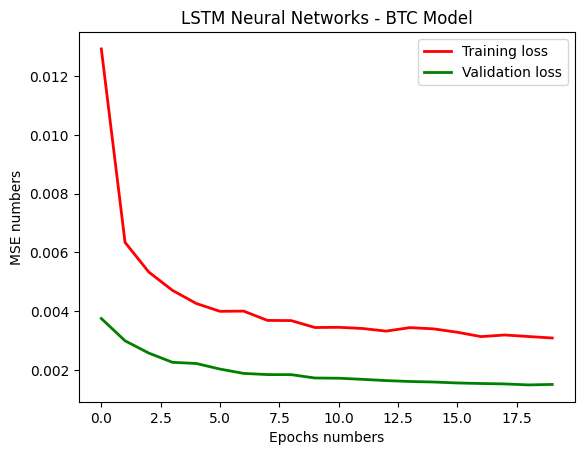

In [14]:
# Plotting the training and validation loss during model training
plt.plot(modelfit.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g', linewidth=2, label='Validation loss')

# Set plot title and axis labels
plt.title('LSTM Neural Networks - BTC Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')

# Display legend to distinguish between training and validation loss
plt.legend()

# Show the plot
plt.show()


In [15]:
# Extract the target values from the test dataset
targets = test_data[aim][window_len:]

# Make predictions using the trained LSTM model on the test data
preds = model.predict(X_test).squeeze()

# Calculate the Mean Absolute Error (MAE) between predictions and actual targets
mae = mean_absolute_error(preds, y_test)

# Display the actual target values
targets.round()


14/14 [==============================] - 0s 1ms/step


Date
2022-09-29    54.0
2022-09-30    53.0
2022-10-01    53.0
2022-10-02    52.0
2022-10-03    54.0
              ... 
2023-11-25    72.0
2023-11-26    70.0
2023-11-27    69.0
2023-11-28    70.0
2023-11-29    70.0
Name: Close, Length: 427, dtype: float64

In [16]:
# Calculate the Mean Squared Error (MSE) between predictions and actual targets
SCORE_MSE = mean_squared_error(preds, y_test)

# Display the calculated MSE score
SCORE_MSE


0.0015034521494925674

In [17]:
# Calculate the R-squared (R2) score between actual targets and predicted values
r2_score = r2_score(y_test, preds)

# Multiply the R2 score by 100 for percentage representation
r2_score * 100


75.81659501128057

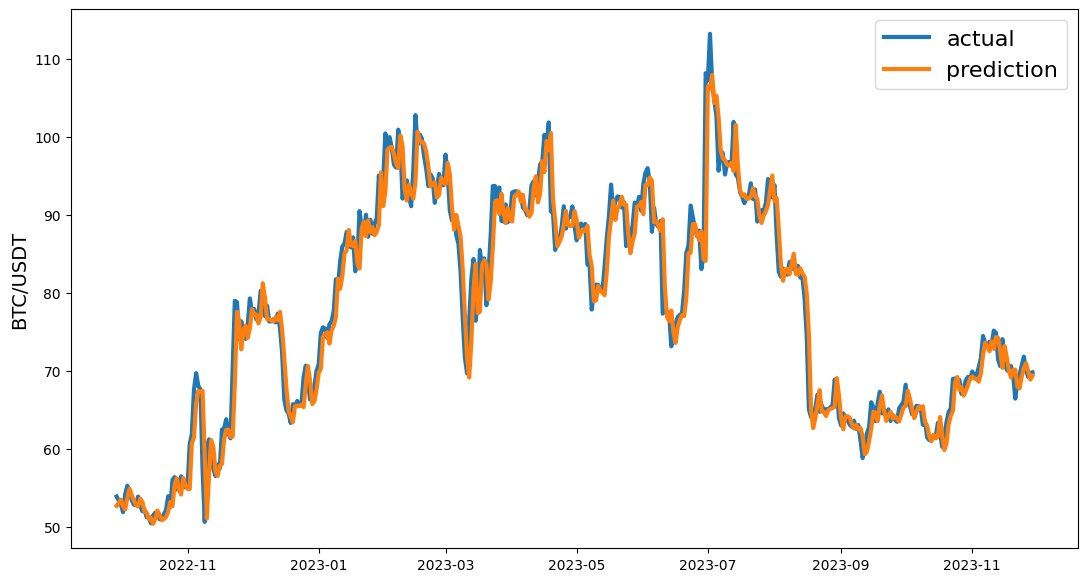

In [18]:
# Generate final predictions by reversing the normalization process
preds = test_data[aim].values[:-window_len] * (preds + 1)

# Create a pandas Series with index and data for predictions
preds = pd.Series(index=targets.index, data=preds)

# Plotting the actual and predicted values
line_plot(targets, preds, 'actual', 'prediction', lw=3)


# 5. Preprocess Data for Binary Classification 

In [19]:
# Assuming 'data' is the DataFrame containing time series data
data['aim_binary'] = (data['Close'] > data['Close'].shift(1)).astype(int)

# Drop NaN values introduced by the shift operation
data = data.dropna()
data.head()


,Open,High,Low,Close,Volume,aim_binary
Date,,,,,,
2018-01-01,231.666000,236.634003,222.203003,229.033005,633142016,0
2018-01-02,228.990005,263.625000,228.990005,255.684006,1237949952,1
2018-01-03,255.695007,260.742004,243.134995,245.367996,3215280128,0
2018-01-04,245.475006,245.475006,227.013000,241.369995,3481550080,0
2018-01-05,241.033997,256.148010,237.880005,249.270996,1710599936,1


In [20]:
# def prepare_data_binary(continuous, aim, window_len=10, zero_base=True, test_size=0.2):
#     X_train = extract_window_data(train_data[continuous.columns], window_len, zero_base)
#     X_test = extract_window_data(test_data[continuous.columns], window_len, zero_base)
#     y_train = train_data[aim][window_len:].values
#     y_test = test_data[aim][window_len:].values
#     if zero_base:
#         y_train = y_train / train_data[aim][:-window_len].values - 1
#         y_test = y_test / test_data[aim][:-window_len].values - 1

#     return train_data, test_data, X_train, X_test, y_train, y_test


In [21]:
# Prepare data for binary classification
aim_binary = 'aim_binary'
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=[aim_binary]), data[aim_binary], test_size=0.2, shuffle=False)


# 6. Binary Classification Model

In [22]:
# Function to build a binary classification model
def build_binary_classification_model(input_data, output_size, neurons, activ_func='sigmoid', dropout=0.3, loss='binary_crossentropy', optimizer='adam'):
    model2 = Sequential()
    # Assuming your time series data has only one feature (e.g., 'Close' column)
    model2.add(LSTM(neurons, input_shape=(X_train.shape[1], 1)))  # Adjust the input shape
    model2.add(Dropout(dropout))
    model2.add(Dense(units=output_size))
    model2.add(Activation(activ_func))
    model2.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model2


In [23]:
# Specify parameters for the binary classification model
binary_lstm_neurons = 50
binary_epochs = 20
batch_size = 32


In [24]:
# Build the binary classification model
binary_model = build_binary_classification_model(X_train, output_size=1, neurons=binary_lstm_neurons)

# Train the binary classification model
binary_modelfit = binary_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=binary_epochs, batch_size=batch_size, verbose=1, shuffle=False)


Epoch 1/20
54/54 [==============================] - 1s 8ms/step - loss: 0.7386 - accuracy: 0.5026 - val_loss: 0.6944 - val_accuracy: 0.4838
Epoch 2/20
54/54 [==============================] - 0s 4ms/step - loss: 0.7393 - accuracy: 0.4829 - val_loss: 0.6923 - val_accuracy: 0.5162
Epoch 3/20
54/54 [==============================] - 0s 3ms/step - loss: 0.7318 - accuracy: 0.4980 - val_loss: 0.7227 - val_accuracy: 0.5162
Epoch 4/20
54/54 [==============================] - 0s 3ms/step - loss: 0.7333 - accuracy: 0.4980 - val_loss: 0.6927 - val_accuracy: 0.5162
Epoch 5/20
54/54 [==============================] - 0s 3ms/step - loss: 0.7221 - accuracy: 0.4933 - val_loss: 0.6925 - val_accuracy: 0.5162
Epoch 6/20
54/54 [==============================] - 0s 3ms/step - loss: 0.7290 - accuracy: 0.4800 - val_loss: 0.6924 - val_accuracy: 0.5162
Epoch 7/20
54/54 [==============================] - 0s 5ms/step - loss: 0.7165 - accuracy: 0.5119 - val_loss: 0.6925 - val_accuracy: 0.5162
Epoch 8/20
54/54 [==

# 7. Binary Classification 

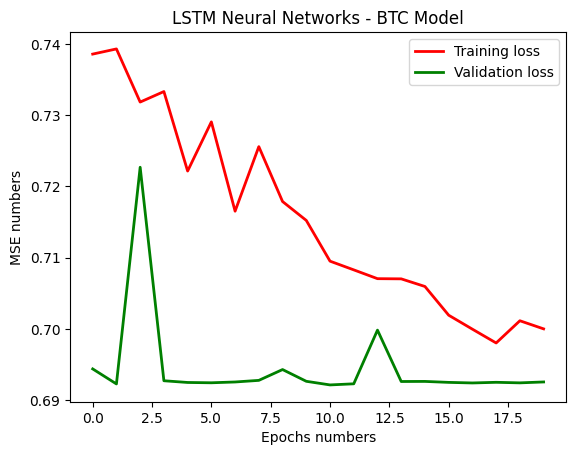

In [25]:
# Plotting the training and validation loss during model training
plt.plot(binary_modelfit.history['loss'], 'r', linewidth=2, label='Training loss')
plt.plot(binary_modelfit.history['val_loss'], 'g', linewidth=2, label='Validation loss')

# Set plot title and axis labels
plt.title('LSTM Neural Networks - BTC Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')

# Display legend to distinguish between training and validation loss
plt.legend()

# Show the plot
plt.show()


In [26]:
# Make predictions using the trained binary classification model on the test data
binary_preds = (binary_model.predict(X_test) > 0.5).astype(int)

# Extract the binary target values from the test dataset
binary_targets = y_test.astype(int)

# Display the actual binary target values
print("Actual Binary Targets:")
print(binary_targets)

# Display the predicted binary target values
print("Predicted Binary Targets:")
print(binary_preds)


14/14 [==============================] - 0s 1ms/step
Actual Binary Targets:
Date
2022-09-24    0
2022-09-25    0
2022-09-26    1
2022-09-27    0
2022-09-28    1
             ..
2023-11-25    1
2023-11-26    0
2023-11-27    0
2023-11-28    1
2023-11-29    1
Name: aim_binary, Length: 432, dtype: int64
Predicted Binary Targets:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1

In [27]:
# Evaluate the binary classification model
binary_preds = (binary_model.predict(X_test) > 0.5).astype(int)
accuracy = accuracy_score(y_test, binary_preds)
print(f'Accuracy: {accuracy}')


14/14 [==============================] - 0s 2ms/step
Accuracy: 0.5162037037037037
